# predict chart type with a random forest classifier
The Plotly Community Feed has more than a million user-generated charts, many of which include data.  I want to use this data to train a model to predict the kinds of design decisions that a human data analyst would make when looking at a table of data:
- What kind of chart to draw?
- What goes on the x axis?
- What goes on the y axis? 
- Are any transforms necisary? 

Conveniently, the precident project vizML has packeged up data from the plotly community feed, along with a package of attributes they calculated from cleaned and de-duplicated data.  As a shortcut, I'll start with their processed attributes. Later, we can go back and collect new data from the plotly community feed to add more information about new types of data -- particularly, about chart types good for visualizing genomic data, like a circos plot.  

### Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import os
from os.path import join
import sys
base_path = os.path.abspath(os.path.join('..'))
if base_path not in sys.path:
    sys.path.append(base_path)


### Data
Data comes from Plotly's community feed of user generated data. Conveniently, the VizML project from MIT Media Lab provides two files for download: raw data extracted from the community feed and the aggrigated features they have extracted from each user-generated plot. The latter contains features and labels for 1,989,068 charts. 

The VizML features needs some cleaning and adjustment before I can use it to train Photon:
- Some charts do not have corresponding data 
- There are many near-duplicates in the data (mostly slightly different charts drawn from the same dataset, ~88% of charts had near-duplicates)
- VizML only labels three possible chart types.  We want photon to be able to draw more types of charts. 

After eliminating charts without data, eliminating charts that combine multiple kinds of data presentations, agressively de-duplicating charts drawn with similar data, and infering nine chart type labels from tick and trace types, I'm left with 110,244 uniqe examples of charts with data. This processed features and labels data is available here: [plotly_data_processed.csv](https://drive.google.com/file/d/16RioCknQirQ5ZiALhTDXIgQ8uDI7JDyB/view?usp=sharing). The data cleaning process is documented in the notebook "Load and Clean Plotly Data".

In [2]:
data_dir_name = '../data'
data_file_name = 'plotly_data_processed.csv'

# full data - use this to train tuned model. It is about 1.6 GB
df = pd.read_csv(os.path.join(data_dir_name, data_file_name)) # uncomment this one to run everything on the full data set of 888k+ charts

# this options loads just the first 10k rows. It is about 57 MB.  For figuring all this out on my laptop. 
# df = pd.read_csv(os.path.join(data_dir_name, data_file_name), nrows=10000) # uncomment this one for the subset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110244 entries, 0 to 110243
Columns: 850 entries, Unnamed: 0 to labels
dtypes: bool(120), float64(726), int64(2), object(2)
memory usage: 626.6+ MB


In [122]:
# take a random subset of data to be able to make and run models on my laptop
# later, skip this step and run df=df_full to run model on full data set

# create a series of weights corresponding to the frequency of each label in the data
# label_weights = df_full.groupby('labels')['labels'].transform('count')
# create random sample 
# subset_size = 10000
# RANDOM_STATE = 42
# df = df_full.sample(n=subset_size, replace=False, weights=label_weights, random_state=RANDOM_STATE)

In [16]:
df.head()

,Unnamed: 0,Unnamed: 0.1,fid,exists-agg-num,exists-agg-has,exists-agg-only_one,exists-agg-all,exists-agg-percentage,length-agg-mean,length-agg-var,...,num_shared_words-agg-min,num_shared_words-agg-max,percent_shared_words-agg-mean,percent_shared_words-agg-var,percent_shared_words-agg-std,percent_shared_words-agg-avg_abs_dev,percent_shared_words-agg-med_abs_dev,percent_shared_words-agg-min,percent_shared_words-agg-max,labels
0,0,0,automata:52280,0.770345,True,False,False,0.770345,0.067238,-0.137411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scatter
1,1,1,barisguclu:21,-0.707945,True,False,False,-0.707945,-0.222991,-0.137411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scatter
2,2,2,glengal:43,-0.707945,True,False,False,-0.707945,-0.225834,-0.137411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bar
3,3,3,eunyong0718:32,-0.707945,True,False,False,-0.707945,-0.225509,-0.137411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scatter
4,4,4,likunyi2:24,2.002253,True,False,False,2.002253,-0.223560,-0.137411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scatter


In [3]:
# features data frame without ids or chart type labels
features = df.drop(['fid', 'labels'], axis=1, inplace=True)

labels = df['labels']

,exists-agg-num,exists-agg-has,exists-agg-only_one,exists-agg-all,exists-agg-percentage,length-agg-mean,length-agg-var,length-agg-std,length-agg-avg_abs_dev,length-agg-med_abs_dev,...,num_shared_words-agg-med_abs_dev,num_shared_words-agg-min,num_shared_words-agg-max,percent_shared_words-agg-mean,percent_shared_words-agg-var,percent_shared_words-agg-std,percent_shared_words-agg-avg_abs_dev,percent_shared_words-agg-med_abs_dev,percent_shared_words-agg-min,percent_shared_words-agg-max
0,0.770345,True,False,False,0.770345,0.067238,-0.137411,-0.207664,-0.207261,-0.154171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.707945,True,False,False,-0.707945,-0.222991,-0.137411,-0.206446,-0.205936,-0.148720,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.707945,True,False,False,-0.707945,-0.225834,-0.137411,-0.207664,-0.207261,-0.154171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.707945,True,False,False,-0.707945,-0.225509,-0.137411,-0.207664,-0.207261,-0.154171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.002253,True,False,False,2.002253,-0.223560,-0.137411,-0.207664,-0.207261,-0.154171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# split train and test data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=.15)
print(X_train.shape, X_test.shape) # to make sure they are what we expect
print(y_train.shape, y_test.shape)

(93707, 846) (16537, 846)
(93707,) (16537,)


In [18]:
# SMOTE - Synthetic Minority Oversampling Technique
# to balance dataset
sm = SMOTE(sampling_strategy = "minority" , random_state = 42)
X_sm, y_sm = sm.fit_sample(X_train, y_train)

In [20]:
print(X_train.shape, X_test.shape) # to make sure they are what we expect
print(y_train.shape, y_test.shape)

(93707, 846) (16537, 846)
(93707,) (16537,)


In [21]:
y_train.head()

81941          box
24877         line
14602    histogram
37499    histogram
83140      scatter
Name: labels, dtype: object

In [24]:
# one-hot encode labels
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
# save a list of column labels for later
chart_names = y_train.columns
y_train.head() # take a peek at one-hot encoded labels

,bar,box,heatmap,histogram,line,pie,sankey,scatter,table
81941,0,1,0,0,0,0,0,0,0
24877,0,0,0,0,1,0,0,0,0
14602,0,0,0,1,0,0,0,0,0
37499,0,0,0,1,0,0,0,0,0
83140,0,0,0,0,0,0,0,1,0


### Tune model hyperparameters
find optimal hyperparameters using a gridsearch

In [26]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [400, 500, 600, 700]
}

# Create a base model to tune
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# this should train a 1*2*4*3 = 24 variations on the model; fitting 3 stratifold folds for each
# 

In [40]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 76.5min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 143.4min finished


{'bootstrap': True, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}


In [41]:
best_estimator = grid_search.best_estimator_

### Define and Train Best Model

In [29]:
model = best_estimator
# Fit on training data
model.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', n_estimators=600)

In [31]:
# predictions 
y_pred = model.predict(X_test)
# Probabilities for each class
probs = model.predict_proba(X_test)
# predicitons as a data frame with chart labels
preds = pd.DataFrame(y_pred)
preds.columns = chart_names

## Model Performance

In [35]:
# Summarize model performance
def evaluate_model(y_test, preds):
    '''prints a lot of model evaluation metrics, returns accuracy'''
    # ROC-AUC is useful -- but for smaller subsets (e.g., 10k), the model tends predict less common
    # chart types zero times, and in that case AUC can't be computed.
    try:
        print('\nArea Under the Curve: {:.2f}\n'.format(roc_auc_score(y_test, preds)))
    except ValueError:
        pass

    print('Accuracy: {:.2f}\n'.format(accuracy_score(y_test, preds)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_test, preds, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_test, preds, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, preds, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_test, preds, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, preds, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, preds, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_test, preds, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_test, preds, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, preds, average='weighted')))

    from sklearn.metrics import classification_report
    print('\nClassification Report\n')
    print(classification_report(y_test, preds, target_names=chart_names))
    
    return accuracy_score(y_test, preds) 

evaluate_model(y_test, preds)


Area Under the Curve: 0.82

Accuracy: 0.71

Micro Precision: 0.90
Micro Recall: 0.71
Micro F1-score: 0.80

Macro Precision: 0.95
Macro Recall: 0.65
Macro F1-score: 0.76

Weighted Precision: 0.91
Weighted Recall: 0.71
Weighted F1-score: 0.79

Classification Report

              precision    recall  f1-score   support

         bar       0.92      0.43      0.59      1188
         box       0.95      0.77      0.85      2055
     heatmap       0.99      0.72      0.84       468
   histogram       0.91      0.78      0.84      1128
        line       0.89      0.77      0.83      6206
         pie       1.00      0.51      0.67       138
      sankey       1.00      0.84      0.92        58
     scatter       0.89      0.68      0.77      5269
       table       1.00      0.33      0.50        27

   micro avg       0.90      0.71      0.80     16537
   macro avg       0.95      0.65      0.76     16537
weighted avg       0.91      0.71      0.79     16537
 samples avg       0.71      0

/Users/devon/opt/anaconda3/envs/photon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.7131281369051219

In [36]:
# confusion matrix
confusion = confusion_matrix(
    y_test.idxmax(1), preds.idxmax(1))
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[1053    2    0    5   73    0    0   55    0]
 [ 381 1589    2   60   11    0    0   12    0]
 [ 126    0  337    1    1    0    0    3    0]
 [ 188   51    0  875    6    0    0    8    0]
 [1034    8    0    7 4783    0    0  374    0]
 [  66    1    0    1    0   70    0    0    0]
 [   9    0    0    0    0    0   49    0    0]
 [1176   13    0   10  500    0    0 3570    0]
 [  18    0    0    0    0    0    0    0    9]]


In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

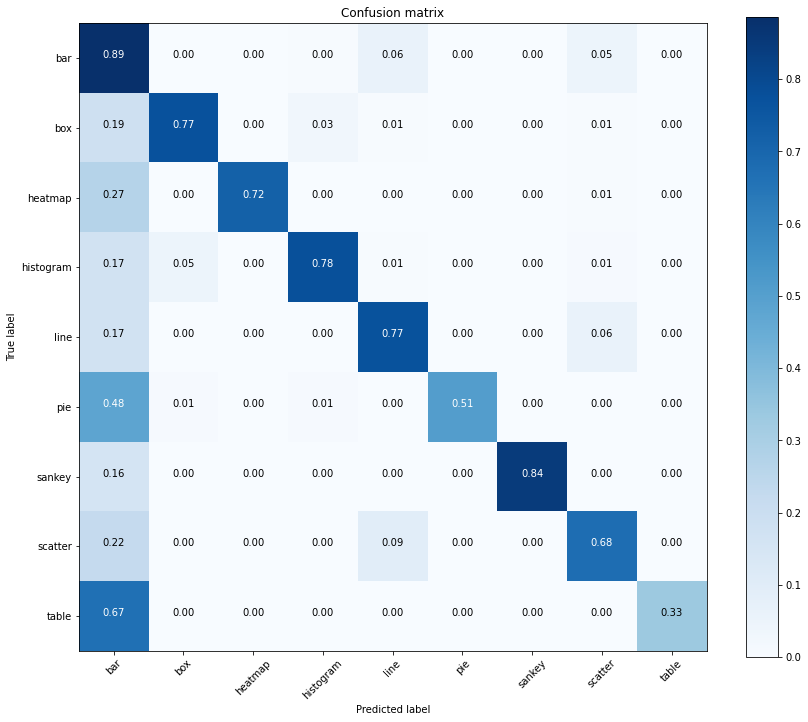

In [34]:
# draw confusion matrix
fig, ax = plt.subplots(figsize = (12,10))
plot_confusion_matrix(confusion, chart_names, normalize=True)

### Train and evaluate selected model on full data set

In [50]:
# re-load full data set, split into train and test sets
df = df_full # uncomment this one to run everything on the full data set of 888k+ charts
# features data frame without ids or chart type labels
features = df.iloc[:,2:]
features.drop('labels', axis=1, inplace=True)
# one-hot encode labels
labels = pd.get_dummies(df['labels'])
# save a list of column labels for later
chart_names = labels.columns
# split train and test data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=.15)
print(X_train.shape, X_test.shape) # to make sure they are what we expect

(755211, 846) (133273, 846)


In [51]:
# define model using best params from above grid search
model = best_estimator
# Fit on training data
model.fit(X_train, y_train)
# predictions 
y_pred = model.predict(X_test)
# probabilities for each class
probs = model.predict_proba(X_test)
# predicitons as a data frame with chart labels
preds = pd.DataFrame(y_pred)
chart_names = labels.columns.tolist()
preds.columns = chart_names

In [52]:
# evaluate
evaluate_model(y_test, preds)


Area Under the Curve: 0.90

Accuracy: 0.85

Micro Precision: 0.94
Micro Recall: 0.85
Micro F1-score: 0.89

Macro Precision: 0.97
Macro Recall: 0.81
Macro F1-score: 0.87

Weighted Precision: 0.94
Weighted Recall: 0.85
Weighted F1-score: 0.89

Classification Report

              precision    recall  f1-score   support

         bar       0.93      0.79      0.86     18623
         box       0.97      0.82      0.89      7308
     heatmap       1.00      0.80      0.89      1879
   histogram       0.93      0.84      0.88      4421
        line       0.96      0.87      0.91     54623
         pie       0.98      0.92      0.95      3879
      sankey       1.00      0.90      0.95       120
     scatter       0.91      0.85      0.88     42370
       table       1.00      0.48      0.65        50

   micro avg       0.94      0.85      0.89    133273
   macro avg       0.97      0.81      0.87    133273
weighted avg       0.94      0.85      0.89    133273
 samples avg       0.85      0

/Users/devon/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8501571961312494

In [61]:
# confusion matrix
confusion = confusion_matrix(
    y_test.idxmax(1), preds.idxmax(1))

In [68]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

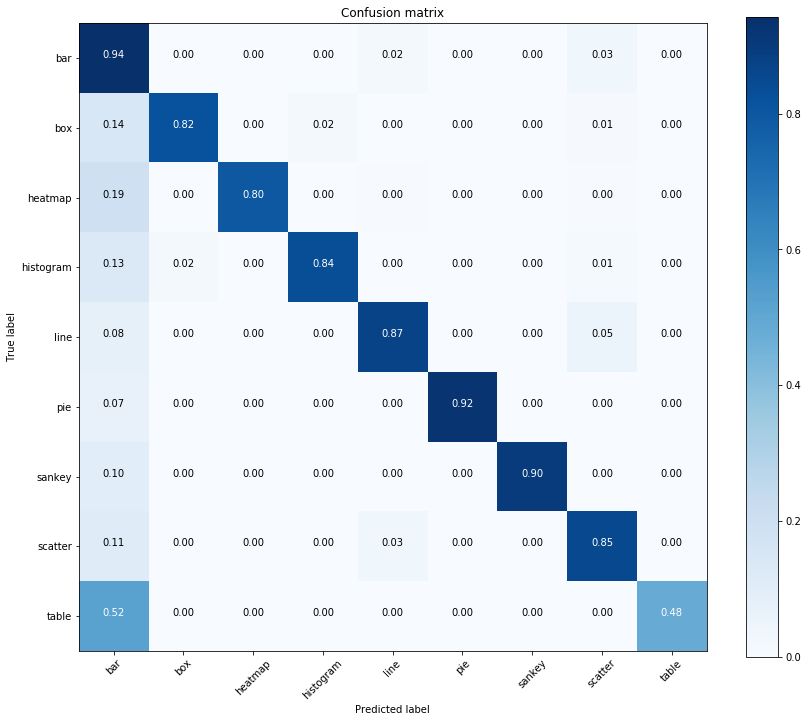

In [71]:
fig, ax = plt.subplots(figsize = (12,10))
plot_confusion_matrix(confusion, chart_names, normalize=True)

In [37]:
def format_feature_importances(model, columns, limit=10):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_importance_table = [
        [columns[i], importances[i]] for i in indices][:limit]
    feature_importance_df = pd.DataFrame(
        feature_importance_table, columns=[
            'feature', 'importance'])
    display(feature_importance_df)

In [38]:
columns = features.columns.tolist()

In [39]:
format_feature_importances(model, columns)

,feature,importance
0,y_in_name-agg-num,0.009446
1,y_in_name-agg-percentage,0.008403
2,x_in_name-agg-percentage,0.007590
3,length-agg-min,0.007346
4,x_in_name-agg-num,0.007223
5,number_of_words_in_name-agg-mean,0.006995
6,y_in_name-agg-has,0.006916
7,field_name_length-agg-mean,0.006693
8,field_name_length-agg-min,0.006574
9,x_in_name-agg-has,0.006310
